# Multi-Offset Downsampling Analysis Notebook

This notebook contains all functions from the multi_offset_downsampling.py script for interactive exploration and testing. The script generates multiple downsampled images, each with a different pixel offset, handling mask bits and producing FITS output with proper headers.

**Key Features:**
- Uses Zarr data from convolved_results directory structure
- Loads PS1 convolved image data from Zarr stores for better performance
- Handles mask bits and produces FITS output with proper headers
- Memory-efficient batch processing with sparse arrays

## 1. Import Required Libraries

Import all necessary libraries including NumPy, Pandas, Zarr, Astropy, Joblib, and other dependencies for astronomical data processing.

In [1]:
import time
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import zarr
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from joblib import Parallel, delayed
from tqdm import tqdm

# Import from existing script
from compute_ps1_skycell_shifts import RELEVANT_WCS_KEYS, build_ps1_wcs, compute_ps1_shift_for_skycell, load_tess_wcs

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Configuration and Path Setup

Define sector, camera, and CCD parameters, set up file paths for TESS FITS data, skycell CSV files, convolved data, registration files, and output directories.

In [21]:
# Set sector, camera, and ccd parameters
sector = 20
camera = 3
ccd = 3

# Generate paths based on parameters
TESS_FITS_PATH = Path(f"/home/kshukawa/syndiff/data/tess_ffi/{sector}_{camera}_{ccd}/tess2020019135923-s00{sector}-{camera}-{ccd}-0165-s_ffic.fits")
SKYCELL_CSV_PATH = Path(f"/home/kshukawa/syndiff/data/skycell_pixel_mapping/sector_{sector:04d}/camera_{camera}/ccd_{ccd}/tess_s{sector:04d}_{camera}_{ccd}_master_skycells_list.csv")
CONVOLVED_DATA_PATH = Path(f"/home/kshukawa/syndiff/data/convolved_results/sector_{sector:04d}_camera_{camera}_ccd_{ccd}.zarr/")
REG_FILES_PATH = f"/home/kshukawa/syndiff/data/skycell_pixel_mapping/sector_{sector:04d}/camera_{camera}/ccd_{ccd}/"
OUTPUT_DIR = Path(f"/home/kshukawa/syndiff/data/shifted_downsamples/sector{sector:04d}_camera{camera}_ccd{ccd}")

# Processing parameters - adjusted for better memory efficiency
N_JOBS = 16  # Number of parallel jobs
SKYCELLS_PER_BATCH = 20  # Skycells per batch for memory management
padding = 480  # Padding value

# Define offsets to process
offsets = np.array(
    [
        [0.0, 0.0],  # dx, dy
        [0.11, 0.03],
        [-0.11, -0.03],
        # [0.1, 0.1],
        # [-0.1, -0.1],
        # [0.1, -0.1],
        # [-0.1, 0.1],
    ]
)

# Set mask bits to ignore (0-indexed)
ignore_mask_bits = [5]

print(f"Configuration set for sector {sector}, camera {camera}, ccd {ccd}")
print(f"TESS FITS path: {TESS_FITS_PATH}")
print(f"Skycell CSV path: {SKYCELL_CSV_PATH}")
print(f"Convolved data path: {CONVOLVED_DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Offsets to process: {len(offsets)}")
print(f"Ignore mask bits: {ignore_mask_bits}")

Configuration set for sector 20, camera 3, ccd 3
TESS FITS path: /home/kshukawa/syndiff/data/tess_ffi/20_3_3/tess2020019135923-s0020-3-3-0165-s_ffic.fits
Skycell CSV path: /home/kshukawa/syndiff/data/skycell_pixel_mapping/sector_0020/camera_3/ccd_3/tess_s0020_3_3_master_skycells_list.csv
Convolved data path: /home/kshukawa/syndiff/data/convolved_results/sector_0020_camera_3_ccd_3.zarr
Output directory: /home/kshukawa/syndiff/data/shifted_downsamples/sector0020_camera3_ccd3
Offsets to process: 3
Ignore mask bits: [5]


## 3. Zarr Data Loading Functions

Implement functions to load Zarr metadata and extract PS1 convolved image and mask data for specific skycells from Zarr stores.

In [22]:
def load_zarr_metadata(sector: int, camera: int, ccd: int, convolved_data_path: Path) -> Path:
    """
    Load Zarr metadata once to avoid repeated file access.

    Returns:
        Path to the zarr store
    """
    zarr_path = convolved_data_path / f"sector_{sector:04d}_camera_{camera}_ccd_{ccd}.zarr"

    if not zarr_path.exists():
        raise FileNotFoundError(f"Zarr store not found: {zarr_path}")

    return zarr_path


def load_zarr_data_for_skycell(skycell_name: str, zarr_store) -> tuple[np.ndarray, np.ndarray]:
    """
    Load PS1 convolved image and mask data from Zarr store for a specific skycell.

    Args:
        skycell_name: Name of the skycell (e.g., "skycell.1234.567")
        zarr_store: Opened Zarr store

    Returns:
        Tuple of (image_data, mask_data) as numpy arrays
    """
    if f"{skycell_name}_data" in zarr_store:
        image_data = zarr_store[f"{skycell_name}_data"]
    else:
        # Try to find arrays by iterating through keys
        available_keys = list(zarr_store.keys()) if hasattr(zarr_store, "keys") else []
        raise ValueError(f"Cannot find image data for cell {skycell_name}. Available keys: {available_keys}")

    # Load mask data (assuming similar structure)
    if f"{skycell_name}_mask" in zarr_store:
        mask_data = zarr_store[f"{skycell_name}_mask"]
    else:
        # If no separate mask array, create a dummy mask of zeros
        mask_data = np.zeros_like(image_data, dtype=np.uint32)

    return image_data, mask_data


print("Zarr data loading functions defined!")

Zarr data loading functions defined!


## 4. Shift Computation Functions

Implement functions to precompute PS1 shifts for each offset pair and skycell, including WCS computations and coordinate transformations.

In [23]:
def precompute_shifts_for_offsets(tess_wcs: WCS, skycell_df: pd.DataFrame, offsets: np.ndarray) -> dict[tuple[float, float], pd.DataFrame]:
    """
    Precompute all PS1 shifts for each offset pair and skycell

    Returns:
        Dictionary mapping (dx, dy) to DataFrame with NAME, shift_x, shift_y
    """
    shift_results = {}

    for dx, dy in tqdm(offsets, desc="Computing shifts"):
        shift_x_list = [None] * len(skycell_df)
        shift_y_list = [None] * len(skycell_df)

        # Group by projection to build each PS1 WCS only once
        for proj, group in skycell_df.groupby("projection"):
            base_row = group.iloc[0]
            ps1_wcs, _ = build_ps1_wcs(base_row)

            # Compute shifts for every skycell in this projection group
            for idx, row in group.iterrows():
                sx, sy = compute_ps1_shift_for_skycell(
                    tess_wcs,
                    dx,
                    dy,
                    float(row["RA"]),
                    float(row["DEC"]),
                    ps1_wcs,
                )
                shift_x_list[idx] = int(round(sx))
                shift_y_list[idx] = int(round(sy))

        # Assemble the DataFrame in original skycell order
        shift_df = pd.DataFrame(
            {
                "NAME": skycell_df["NAME"],
                "shift_x": shift_x_list,
                "shift_y": shift_y_list,
            }
        )

        shift_results[(dx, dy)] = shift_df

    return shift_results


print("Shift computation functions defined!")

Shift computation functions defined!


## 5. Batch Processing Functions

Implement the core batch processing function that handles skycell data processing, registration mapping, pixel binning, and sparse array operations for memory efficiency.

In [ ]:
def process_skycell_batch(
    batch_idx: int, reg_files: list[str], skycell_names: list[str], offsets: np.ndarray, shifts_dict: dict[tuple[float, float], pd.DataFrame], tess_shape: tuple[int, int], zarr_path: Path, padding: int = 500, ignore_mask_bits: list[int] = []
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Process a batch of skycells using sparse arrays for memory efficiency

    Returns:
        Tuple of (indices, sums, counts, mask_counts) where:
        - indices: Array of TESS pixel indices (1D linearized from y,x)
        - sums: Array of shape (len(indices), num_offsets) with sum values
        - counts: Array of shape (len(indices), num_offsets) with count values
        - mask_counts: Array of shape (len(indices), num_offsets) with mask count values
    """
    t_y, t_x = tess_shape
    num_offsets = len(offsets)

    # Lists to collect values (will convert to arrays later)
    all_indices = []
    all_sums = []
    all_counts = []
    all_mask_counts = []

    # Create mask for ignoring specific bits
    ignore_mask = 0
    for bit in ignore_mask_bits:
        ignore_mask |= 1 << bit

    # Process each skycell in the batch
    zarr_store = zarr.open(str(zarr_path), mode="r")
    for sc_idx, (reg_file, skycell_name) in enumerate(zip(reg_files, skycell_names)):
        try:
            # Load registration mapping
            with fits.open(reg_file) as hdul:
                ps1_assignment = hdul[1].data.astype(int)

            # Prepare for binning
            pind = ps1_assignment.ravel()
            sort_ind = np.argsort(pind)

            # Get valid TESS pixels
            tess_pixels = np.unique(pind[np.isfinite(pind)]).astype(int)
            tess_pixels = tess_pixels[tess_pixels >= 0]

            if len(tess_pixels) == 0:
                continue

            # Calculate breaks for binning
            breaks = np.where(np.diff(pind[sort_ind]) > 0)[0] + 1
            breaks = np.append(breaks, len(sort_ind))

            # Try to load PS1 data from Zarr store
            try:
                # Load PS1 data and mask from Zarr
                ps1_data, ps1_mask = load_zarr_data_for_skycell(skycell_name, zarr_store)

                # If no padding or insufficient padding, use the full data
                ps1_base = ps1_data
                ps1_mask_base = ps1_mask

                # Initialize arrays for each skycell's results
                pixel_sums = np.zeros((len(tess_pixels), num_offsets), dtype=np.float32)
                pixel_counts = np.zeros((len(tess_pixels), num_offsets), dtype=np.int32)
                pixel_mask_counts = np.zeros((len(tess_pixels), num_offsets), dtype=np.int32)

                # Process each offset
                for offset_idx, (dx, dy) in enumerate(offsets):
                    # Get shifts from precomputed values
                    shift_df = shifts_dict[(dx, dy)]
                    row_idx = shift_df.index[shift_df["NAME"] == skycell_name].tolist()

                    if not row_idx:
                        continue

                    sx = shift_df.loc[row_idx[0], "shift_x"]
                    sy = shift_df.loc[row_idx[0], "shift_y"]

                    # Apply the shift (integer pixel shifts only - no interpolation)
                    ps1_shifted = np.roll(ps1_base, (sy, sx), axis=(0, 1))
                    ps1_mask_shifted = np.roll(ps1_mask_base, (sy, sx), axis=(0, 1))

                    # Sort the shifted data
                    ps1_rav = ps1_shifted.ravel()[sort_ind]
                    ps1_mask_rav = ps1_mask_shifted.ravel()[sort_ind]

                    # Compute sums for each TESS pixel
                    sums = np.zeros(len(breaks) - 1, dtype=np.float32)
                    counts = np.zeros(len(breaks) - 1, dtype=np.int32)
                    mask_counts = np.zeros(len(breaks) - 1, dtype=np.int32)

                    for i in range(len(breaks) - 1):
                        slice_data = ps1_rav[breaks[i] : breaks[i + 1]]
                        slice_mask = ps1_mask_rav[breaks[i] : breaks[i + 1]]

                        # Count pixels that should be ignored based on mask bits
                        ignored_pixels = (slice_mask & ignore_mask) > 0

                        # Count all pixels for denominator
                        counts[i] = len(slice_data)

                        # Sum only non-masked pixels
                        sums[i] = np.sum(slice_data[~ignored_pixels])

                        # Count masked pixels for reference
                        mask_counts[i] = np.sum(slice_mask != 0)

                    # Store the results for this offset
                    pixel_sums[:, offset_idx] = sums
                    pixel_counts[:, offset_idx] = counts
                    pixel_mask_counts[:, offset_idx] = mask_counts

                # Add all valid pixels from this skycell to our results
                # Filter out pixels outside the image bounds
                valid_mask = (tess_pixels // t_x < t_y) & (tess_pixels % t_x < t_x)

                if np.any(valid_mask):
                    all_indices.append(tess_pixels[valid_mask])
                    all_sums.append(pixel_sums[valid_mask])
                    all_counts.append(pixel_counts[valid_mask])
                    all_mask_counts.append(pixel_mask_counts[valid_mask])

            except Exception as e:
                print(f"Error processing PS1 data for skycell {skycell_name}: {e}")
                continue

        except Exception as e:
            print(f"Error processing registration for skycell {skycell_name}: {e}")

    print(f"Completed batch {batch_idx + 1}")

    # Convert lists to arrays
    if all_indices:
        indices = np.concatenate(all_indices)
        sums = np.vstack(all_sums)
        counts = np.vstack(all_counts)
        mask_counts = np.vstack(all_mask_counts)
    else:
        # Return empty arrays if no data
        indices = np.array([], dtype=int)
        sums = np.zeros((0, num_offsets), dtype=np.float32)
        counts = np.zeros((0, num_offsets), dtype=np.int32)
        mask_counts = np.zeros((0, num_offsets), dtype=np.int32)

    return indices, sums, counts, mask_counts


print("Batch processing functions defined!")

Batch processing functions defined!


## 6. FITS Header Creation Functions

Implement functions to create syndiff headers based on TESS headers, copying relevant WCS and metadata information for output FITS files.

In [25]:
def create_syndiff_header(tess_header):
    """
    Create a header for the syndiff output based on the TESS header.
    """
    # First, copy specific keywords
    keys_to_copy = ["TELESCOP", "INSTRUME", "CAMERA", "CCD"]
    syndiff_header = fits.Header()

    for key in keys_to_copy:
        if key in tess_header:
            syndiff_header.set(key, tess_header[key], tess_header.comments.get(key, ""))

    # Set PS1 date information
    syndiff_header.set("MJD-OBS", "55197.00000", "TSTART of PS1")
    syndiff_header.set("DATE-OBS", "2010-01-01T00:00:00.000", "TSTART of PS1")
    syndiff_header.set("DATE-END", "2015-01-01T00:00:00.000", "TSTOP of PS1")

    # Copy WCS and quality information
    keys_to_copy = ["RADESYS", "EQUINOX", "WCSAXES", "CTYPE1", "CTYPE2", "CRVAL1", "CRVAL2", "CRPIX1", "CRPIX2", "CD1_1", "CD1_2", "CD2_1", "CD2_2", "DQUALITY", "IMAGTYPE"]

    for key in tess_header:
        if key.startswith(("A_", "B_", "AP_", "BP_", "RA_", "DEC_", "ROLL_")) or key in keys_to_copy:
            syndiff_header.set(key, tess_header[key], tess_header.comments.get(key, ""))

    # Add syndiff tag
    syndiff_header.set("SYNDIFF", True, "Syndiff template")

    return syndiff_header


print("FITS header creation functions defined!")

FITS header creation functions defined!


## 7. Output Saving Functions

Implement functions to save processing results as FITS files with proper headers, including both simple and extended formats with multiple HDU extensions.

In [26]:
def save_fits_outputs(output_dir: Path, results: np.ndarray, offsets: np.ndarray, tess_header: fits.Header, save_extensions: bool = True):
    """
    Save the results as FITS files.

    Args:
        output_dir: Directory to save outputs
        results: Array of shape (num_offsets, 3, ny, nx) with:
            [0] = sum of PS1 pixel values
            [1] = count of PS1 pixels
            [2] = count of masked PS1 pixels
        offsets: Array of (dx, dy) pairs
        tess_header: Header from TESS file to use as a base
        save_extensions: Whether to save data, count and mask as HDU extensions
    """
    # Create syndiff header based on TESS header
    syndiff_header = create_syndiff_header(tess_header)

    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save each offset result as a FITS file
    for idx, (dx, dy) in enumerate(offsets):
        # Calculate final image (handle division by zero)
        mask = results[idx, 1] > 0  # Pixels with counts
        final_image = np.zeros_like(results[idx, 0])
        final_image[mask] = results[idx, 0][mask] / results[idx, 1][mask]

        # Update header with offset information
        offset_header = syndiff_header.copy()
        offset_header["DX_SHIFT"] = (dx, "TESS pixel x shift")
        offset_header["DY_SHIFT"] = (dy, "TESS pixel y shift")

        # File with just the data
        primary_hdu = fits.PrimaryHDU(data=final_image, header=offset_header)
        hdu_list = fits.HDUList([primary_hdu])
        output_filename = output_dir / f"_dx{dx:.3f}_dy{dy:.3f}.fits"
        hdu_list.writeto(output_filename, overwrite=True)

        if save_extensions:
            # File with data, count, and mask as extensions
            primary_hdu = fits.PrimaryHDU(header=offset_header)
            hdu1 = fits.ImageHDU(data=final_image, header=offset_header, name="FLUX")
            hdu2 = fits.ImageHDU(data=results[idx, 1].astype(np.int32), header=offset_header, name="COUNT")
            hdu3 = fits.ImageHDU(data=results[idx, 2].astype(np.int32), header=offset_header, name="MASK")

            hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3])
            output_filename = output_dir / f"downsampled_dx{dx:.3f}_dy{dy:.3f}_extended.fits"
            hdu_list.writeto(output_filename, overwrite=True)


print("Output saving functions defined!")

Output saving functions defined!


## 8. Manual Processing Steps

The following cells provide step-by-step execution of the main processing workflow. You can run each cell individually to manually inspect the process, load data, precompute shifts, process batches, combine results, and save outputs with timing and progress information.

### Step 1: Create Output Directory and Load TESS Data

In [27]:
# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Created output directory: {OUTPUT_DIR}")

# Load TESS data and WCS
print("Loading TESS data and WCS...")
start_time = time.time()
tess_wcs, tess_dims = load_tess_wcs(TESS_FITS_PATH)

with fits.open(TESS_FITS_PATH) as hdul:
    # Find HDU with data
    hdu_idx = 1 if len(hdul) > 1 and getattr(hdul[1], "data", None) is not None else 0
    tess_data = hdul[hdu_idx].data.astype(np.float32)
    tess_header = hdul[hdu_idx].header

print(f"TESS data shape: {tess_data.shape}")
print(f"TESS WCS loaded successfully")
print(f"Time elapsed: {time.time() - start_time:.2f} seconds")

Created output directory: /home/kshukawa/syndiff/data/shifted_downsamples/sector0020_camera3_ccd3
Loading TESS data and WCS...
TESS data shape: (2078, 2136)
TESS WCS loaded successfully
Time elapsed: 0.07 seconds


Set MJD-END to 58867.605545 from DATE-END'. [astropy.wcs.wcs]


### Step 2: Load Skycell Information

In [28]:
# Load skycell info
print("Loading skycell info...")
step_start = time.time()

usecols = ["NAME", "RA", "DEC", "projection"] + RELEVANT_WCS_KEYS
skycell_df = pd.read_csv(SKYCELL_CSV_PATH, usecols=usecols)

print(f"Loaded {len(skycell_df)} skycells")
print(f"Columns: {list(skycell_df.columns)}")
print(f"Unique projections: {skycell_df['projection'].nunique()}")
print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

# Display first few rows
print("\nFirst 5 skycells:")
display(skycell_df.head())

Loading skycell info...
Loaded 1036 skycells
Columns: ['NAME', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'NAXIS1', 'NAXIS2', 'RADESYS', 'CTYPE1', 'CTYPE2', 'RA', 'DEC', 'projection']
Unique projections: 17
Time elapsed: 0.01 seconds

First 5 skycells:


,NAME,CRVAL1,CRVAL2,CRPIX1,CRPIX2,CDELT1,CDELT2,PC1_1,PC1_2,PC2_1,PC2_2,NAXIS1,NAXIS2,RADESYS,CTYPE1,CTYPE2,RA,DEC,projection
0,skycell.2556.080,196.363632,70.0,29663.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,202.115764,71.339009,2556
1,skycell.2556.081,196.363632,70.0,23778.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,200.843357,71.373516,2556
2,skycell.2556.082,196.363632,70.0,17893.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,199.566507,71.399451,2556
3,skycell.2556.083,196.363632,70.0,12008.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,198.286465,71.416765,2556
4,skycell.2556.084,196.363632,70.0,6123.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,197.004500,71.425429,2556


### Step 3: Load Zarr Metadata

In [29]:
# Load Zarr metadata once for efficient access
print("Loading Zarr metadata...")
step_start = time.time()

zarr_path = CONVOLVED_DATA_PATH
print(f"Zarr path: {zarr_path}")
print(f"Zarr path exists: {zarr_path.exists()}")

if zarr_path.exists():
    # Try to open and inspect the zarr store
    try:
        test_store = zarr.open(str(zarr_path), mode="r")
        available_keys = list(test_store.keys()) if hasattr(test_store, "keys") else []
        print(f"Number of arrays in Zarr store: {len(available_keys)}")
        if len(available_keys) > 0:
            print(f"First 5 keys: {available_keys[:5]}")
            if len(available_keys) > 5:
                print(f"... and {len(available_keys) - 5} more")
    except Exception as e:
        print(f"Error inspecting Zarr store: {e}")
else:
    print("Warning: Zarr path does not exist!")

print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

Loading Zarr metadata...
Zarr path: /home/kshukawa/syndiff/data/convolved_results/sector_0020_camera_3_ccd_3.zarr
Zarr path exists: True
Number of arrays in Zarr store: 2072
First 5 keys: ['skycell.2611.081_data', 'skycell.2557.070_data', 'skycell.2587.024_mask', 'skycell.2612.094_data', 'skycell.2611.074_mask']
... and 2067 more
Time elapsed: 1.31 seconds


### Step 4: Precompute Shifts for All Offsets

In [30]:
# Precompute shifts for all offsets
print("Precomputing shifts for all offsets...")
step_start = time.time()

shifts_dict = precompute_shifts_for_offsets(tess_wcs, skycell_df, offsets)

print(f"Precomputed shifts for {len(offsets)} offsets")
for dx, dy in offsets:
    shift_df = shifts_dict[(dx, dy)]
    print(f"  Offset ({dx:6.3f}, {dy:6.3f}): {len(shift_df)} shifts computed")

print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

# Show example shifts for first offset
first_offset = tuple(offsets[0])
example_shifts = shifts_dict[first_offset].head()
print(f"\nExample shifts for offset {first_offset}:")
display(example_shifts)

Precomputing shifts for all offsets...


Computing shifts: 100%|██████████| 3/3 [00:12<00:00,  4.22s/it]

Precomputed shifts for 3 offsets
  Offset ( 0.000,  0.000): 1036 shifts computed
  Offset ( 0.110,  0.030): 1036 shifts computed
  Offset (-0.110, -0.030): 1036 shifts computed
Time elapsed: 12.66 seconds

Example shifts for offset (np.float64(0.0), np.float64(0.0)):


,NAME,shift_x,shift_y
0,skycell.2556.080,0,0
1,skycell.2556.081,0,0
2,skycell.2556.082,0,0
3,skycell.2556.083,0,0
4,skycell.2556.084,0,0


### Step 5: Get Registration Files and Prepare Batches

In [31]:
# Get registration files
print("Getting registration files...")
step_start = time.time()

reg_files = sorted(glob(REG_FILES_PATH + "/*skycell.*.fits.gz"))
skycell_names = [Path(f).stem.split("_")[4][:-5] for f in reg_files]  # Extract skycell names

print(f"Found {len(reg_files)} registration files")
print(f"Example registration file: {reg_files[0] if reg_files else 'None'}")
print(f"Example skycell name: {skycell_names[0] if skycell_names else 'None'}")

# Split into batches
num_batches = (len(reg_files) + SKYCELLS_PER_BATCH - 1) // SKYCELLS_PER_BATCH
print(f"Processing {len(reg_files)} skycells in {num_batches} batches of {SKYCELLS_PER_BATCH}")

reg_batches = np.array_split(reg_files, num_batches)
name_batches = np.array_split(skycell_names, num_batches)

print(f"Batch sizes: {[len(batch) for batch in reg_batches]}")
print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

Getting registration files...
Found 1036 registration files
Example registration file: /home/kshukawa/syndiff/data/skycell_pixel_mapping/sector_0020/camera_3/ccd_3/tess_s0020_3_3_skycell.2556.080.fits.gz
Example skycell name: skycell.2556.080
Processing 1036 skycells in 52 batches of 20
Batch sizes: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19]
Time elapsed: 0.01 seconds


### Step 6: Process Batches (Sequential for Testing)

In [32]:
batch_idx = 2
reg_files = reg_batches[0]
skycell_names = name_batches[0]
offsets = offsets
shifts_dict = shifts_dict
tess_shape = tess_data.shape
zarr_path = zarr_path
padding = padding
ignore_mask_bits = ignore_mask_bits

t_y, t_x = tess_shape
num_offsets = len(offsets)

# Lists to collect values (will convert to arrays later)
all_indices = []
all_sums = []
all_counts = []
all_mask_counts = []

# Create mask for ignoring specific bits
ignore_mask = 0
for bit in ignore_mask_bits:
    ignore_mask |= 1 << bit

In [33]:
zarr_store = zarr.open(str(zarr_path), mode="r")

In [34]:
sc_idx = 2
reg_file, skycell_name = reg_files[sc_idx], skycell_names[sc_idx]

with fits.open(reg_file) as hdul:
    ps1_assignment = hdul[1].data.astype(int)

# Prepare for binning
pind = ps1_assignment.ravel()
sort_ind = np.argsort(pind)

# Get valid TESS pixels
tess_pixels = np.unique(pind[np.isfinite(pind)]).astype(int)
tess_pixels = tess_pixels[tess_pixels >= 0]

# Calculate breaks for binning
breaks = np.where(np.diff(pind[sort_ind]) > 0)[0] + 1
breaks = np.append(breaks, len(sort_ind))

In [35]:
skycell_name

np.str_('skycell.2556.082')

In [36]:
ps1_assignment.shape

(6350, 6365)

In [37]:
ps1_data, ps1_mask = load_zarr_data_for_skycell(skycell_name, zarr_store)

In [38]:
ps1_data.shape

(6350, 6365)

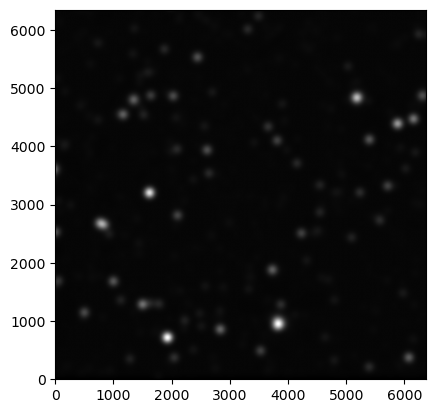

In [39]:
plt.imshow(ps1_data, origin="lower", cmap="gray")

In [55]:
print(np.binary_repr(8251, width=16))

0010000000111011


In [57]:
print(np.binary_repr(8235, width=16))

0010000000101011


In [56]:
print(np.binary_repr(9275, width=16))


0010010000111011


In [61]:
9278 & 1 << 13, 8255 & 1 << 13, 4096 & 1 << 13

(8192, 8192, 0)

In [65]:
1 << 1

2

In [62]:
2**13

8192

In [66]:
8252 & 1 << 12

0

In [70]:
8239 & 1 << 5

32

In [68]:
print(np.binary_repr(8239, width=16))


0010000000101111


In [40]:
ps1_mask_np = ps1_mask[:6350, :6365]

In [41]:
ps1_mask_np.dtype

dtype('uint8')

In [46]:
ps1_mask_np

array([[ 46,  46,  46, ...,  59,  59,  59],
       [ 46,  42,  42, ...,  59,  59,  59],
       [ 46,  46,   8, ...,  59,  59,  59],
       ...,
       [ 63, 184, 128, ...,  43,  63,  63],
       [ 63, 184, 184, ...,  63,  63,  63],
       [ 63,  63,  63, ...,  63,  63,  63]],
      shape=(6350, 6365), dtype=uint8)

In [74]:
# The bitmask data, restructured to handle multiple flags on the same bit.
PS1_MASK_MAP = {
    1: ["DETECTOR"],  # Bit 0
    2: ["FLAT"],  # Bit 1
    4: ["DARK"],  # Bit 2
    8: ["BLANK"],  # Bit 3
    16: ["CTE"],  # Bit 4
    32: ["SAT"],  # Bit 5
    64: ["LOW"],  # Bit 6
    128: ["SUSPECT", "BURNTOOL"],  # Bit 7
    256: ["CR"],  # Bit 8
    512: ["SPIKE"],  # Bit 9
    1024: ["GHOST"],  # Bit 10
    2048: ["STREAK"],  # Bit 11
    4096: ["STARCORE"],  # Bit 12
    8192: ["CONV.BAD"],  # Bit 13
    16384: ["CONV.POOR"],  # Bit 14
}


def get_ps1_flags(mask_value: int) -> list[str]:
    """
    Decodes an integer mask value to identify which PS1 flags are set.

    Args:
        mask_value: The integer value from a data quality mask.

    Returns:
        A list of strings, where each string is the name of an active flag.
    """
    active_flags = []
    # Iterate through each bit value and its corresponding flag names
    for bit_val, flag_names in PS1_MASK_MAP.items():
        # Check if the bit is set in the input value using bitwise AND
        if mask_value & bit_val:
            active_flags.extend(flag_names)

    return active_flags


In [75]:
get_ps1_flags(16384)

['CONV.POOR']

In [77]:
get_ps1_flags(8239)

['DETECTOR', 'FLAT', 'DARK', 'BLANK', 'SAT', 'CONV.BAD']

In [78]:
get_ps1_flags(16384)

['CONV.POOR']

In [79]:
get_ps1_flags(9278)

['FLAT', 'DARK', 'BLANK', 'CTE', 'SAT', 'GHOST', 'CONV.BAD']

In [80]:
get_ps1_flags(8255)

['DETECTOR', 'FLAT', 'DARK', 'BLANK', 'CTE', 'SAT', 'CONV.BAD']

In [81]:
get_ps1_flags(4096)

['STARCORE']

In [82]:
get_ps1_flags(20608)

['SUSPECT', 'BURNTOOL', 'STARCORE', 'CONV.POOR']

In [83]:
get_ps1_flags(8255)

['DETECTOR', 'FLAT', 'DARK', 'BLANK', 'CTE', 'SAT', 'CONV.BAD']

In [71]:
bit_num = 12
plt.figure(figsize=(10, 10))
plt.imshow((ps1_mask_np & 1 << bit_num) == 2**bit_num, origin="lower", cmap="gray")

OverflowError: Python integer 4096 out of bounds for uint8

<Figure size 1000x1000 with 0 Axes>

In [ ]:
plt.imshow(ps1_data, origin="lower", cmap="gray")


In [24]:
ps1_base = ps1_data
ps1_mask_base = ps1_mask

# Initialize arrays for each skycell's results
pixel_sums = np.zeros((len(tess_pixels), num_offsets), dtype=np.float32)
pixel_counts = np.zeros((len(tess_pixels), num_offsets), dtype=np.int32)
pixel_mask_counts = np.zeros((len(tess_pixels), num_offsets), dtype=np.int32)

In [25]:
skycell_df

,NAME,CRVAL1,CRVAL2,CRPIX1,CRPIX2,CDELT1,CDELT2,PC1_1,PC1_2,PC2_1,PC2_2,NAXIS1,NAXIS2,RADESYS,CTYPE1,CTYPE2,RA,DEC,projection
0,skycell.2556.080,196.363632,70.0,29663.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,202.115764,71.339009,2556
1,skycell.2556.081,196.363632,70.0,23778.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,200.843357,71.373516,2556
2,skycell.2556.082,196.363632,70.0,17893.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,199.566507,71.399451,2556
3,skycell.2556.083,196.363632,70.0,12008.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,198.286465,71.416765,2556
4,skycell.2556.084,196.363632,70.0,6123.5,-17370.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6365,6350,FK5,RA---TAN,DEC--TAN,197.004500,71.425429,2556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,skycell.2629.049,240.000000,82.0,-23763.0,6191.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6481,6429,FK5,RA---TAN,DEC--TAN,227.085966,81.583385,2629
1032,skycell.2629.057,240.000000,82.0,-11761.0,242.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6481,6429,FK5,RA---TAN,DEC--TAN,232.362893,82.137576,2629
1033,skycell.2629.058,240.000000,82.0,-17762.0,242.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6481,6429,FK5,RA---TAN,DEC--TAN,229.367914,82.072039,2629
1034,skycell.2629.059,240.000000,82.0,-23763.0,242.0,0.000069,0.000069,-1.0,0.0,-0.0,1.0,6481,6429,FK5,RA---TAN,DEC--TAN,226.430531,81.985531,2629


In [26]:
# Process each offset
for offset_idx, (dx, dy) in enumerate(offsets):
    # Get shifts from precomputed values
    shift_df = shifts_dict[(dx, dy)]
    row_idx = shift_df.index[shift_df["NAME"] == skycell_name].tolist()

    if not row_idx:
        continue

    sx = shift_df.loc[row_idx[0], "shift_x"]
    sy = shift_df.loc[row_idx[0], "shift_y"]

    # Apply the shift (integer pixel shifts only - no interpolation)
    ps1_shifted = np.roll(ps1_base, (sy, sx), axis=(0, 1))
    ps1_mask_shifted = np.roll(ps1_mask_base, (sy, sx), axis=(0, 1))

    # Sort the shifted data
    ps1_rav = ps1_shifted.ravel()[sort_ind]
    ps1_mask_rav = ps1_mask_shifted.ravel()[sort_ind]

    # Compute sums for each TESS pixel
    sums = np.zeros(len(breaks) - 1, dtype=np.float32)
    counts = np.zeros(len(breaks) - 1, dtype=np.int32)
    mask_counts = np.zeros(len(breaks) - 1, dtype=np.int32)

    for i in range(len(breaks) - 1):
        slice_data = ps1_rav[breaks[i] : breaks[i + 1]]
        slice_mask = ps1_mask_rav[breaks[i] : breaks[i + 1]]

        # Count pixels that should be ignored based on mask bits
        ignored_pixels = (slice_mask & ignore_mask) > 0

        # Count all pixels for denominator
        counts[i] = len(slice_data)

        # Sum only non-masked pixels
        sums[i] = np.sum(slice_data[~ignored_pixels])

        # Count masked pixels for reference
        mask_counts[i] = np.sum(slice_mask != 0)

    # Store the results for this offset
    pixel_sums[:, offset_idx] = sums
    pixel_counts[:, offset_idx] = counts
    pixel_mask_counts[:, offset_idx] = mask_counts

# Add all valid pixels from this skycell to our results
# Filter out pixels outside the image bounds
valid_mask = (tess_pixels // t_x < t_y) & (tess_pixels % t_x < t_x)

if np.any(valid_mask):
    all_indices.append(tess_pixels[valid_mask])
    all_sums.append(pixel_sums[valid_mask])
    all_counts.append(pixel_counts[valid_mask])
    all_mask_counts.append(pixel_mask_counts[valid_mask])

# Convert lists to arrays
if all_indices:
    indices = np.concatenate(all_indices)
    sums = np.vstack(all_sums)
    counts = np.vstack(all_counts)
    mask_counts = np.vstack(all_mask_counts)
else:
    # Return empty arrays if no data
    indices = np.array([], dtype=int)
    sums = np.zeros((0, num_offsets), dtype=np.float32)
    counts = np.zeros((0, num_offsets), dtype=np.int32)
    mask_counts = np.zeros((0, num_offsets), dtype=np.int32)

results = (indices, sums, counts, mask_counts)

### Step 7: Process All Batches in Parallel

In [33]:
# Process all batches in parallel
N_JOBS = 40
print(f"Processing all {num_batches} batches in parallel with {N_JOBS} jobs...")
step_start = time.time()

results = Parallel(n_jobs=N_JOBS)(delayed(process_skycell_batch)(i, reg_batch, name_batch, offsets, shifts_dict, tess_data.shape, zarr_path, padding=padding, ignore_mask_bits=ignore_mask_bits) for i, (reg_batch, name_batch) in enumerate(zip(reg_batches, name_batches)))

print(f"All batches completed!")
print(f"Number of batch results: {len(results)}")
print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

Processing all 52 batches in parallel with 40 jobs...
Completed batch 1
Completed batch 4
Completed batch 15
Completed batch 8
Completed batch 3
Completed batch 6
Completed batch 39
Completed batch 31
Completed batch 2
Completed batch 5
Completed batch 35
Completed batch 20
Completed batch 7
Completed batch 25
Completed batch 23
Completed batch 38
Completed batch 40
Completed batch 14
Completed batch 12
Completed batch 18
Completed batch 11
Completed batch 36
Completed batch 9
Completed batch 32
Completed batch 10
Completed batch 21
Completed batch 30
Completed batch 33
Completed batch 22
Completed batch 16
Completed batch 37
Completed batch 28
Completed batch 29
Completed batch 34
Completed batch 13
Completed batch 24
Completed batch 19
Completed batch 17
Completed batch 26
Completed batch 27
Completed batch 43
Completed batch 41
Completed batch 42
Completed batch 52
Completed batch 49
Completed batch 46
Completed batch 50
Completed batch 45
Completed batch 47
Completed batch 51
Compl

### Step 8: Combine Results

In [34]:
# Combine results using the sparse array approach
print("Combining results...")
step_start = time.time()

all_indices = []
all_sums = []
all_counts = []
all_mask_counts = []

for indices, sums, counts, mask_counts in results:
    if len(indices) > 0:
        all_indices.append(indices)
        all_sums.append(sums)
        all_counts.append(counts)
        all_mask_counts.append(mask_counts)

print(f"Number of non-empty batch results: {len(all_indices)}")

# Concatenate all results
if all_indices:
    combined_indices = np.concatenate(all_indices)
    combined_sums = np.vstack(all_sums)
    combined_counts = np.vstack(all_counts)
    combined_mask_counts = np.vstack(all_mask_counts)

    print(f"Combined arrays:")
    print(f"  Total pixels: {len(combined_indices)}")
    print(f"  Unique pixels: {len(np.unique(combined_indices))}")

    # Handle duplicate pixels (from different skycells)
    if len(combined_indices) > len(np.unique(combined_indices)):
        print("Handling duplicate pixels...")
        # Find unique indices and their positions
        unique_indices, inverse_indices = np.unique(combined_indices, return_inverse=True)

        # Initialize arrays for the consolidated results
        unique_sums = np.zeros((len(unique_indices), len(offsets)), dtype=np.float32)
        unique_counts = np.zeros((len(unique_indices), len(offsets)), dtype=np.int32)
        unique_mask_counts = np.zeros((len(unique_indices), len(offsets)), dtype=np.int32)

        # Use np.add.at for efficient aggregation by index
        np.add.at(unique_sums, inverse_indices, combined_sums)
        np.add.at(unique_counts, inverse_indices, combined_counts)
        np.add.at(unique_mask_counts, inverse_indices, combined_mask_counts)

        # Replace with deduplicated arrays
        combined_indices = unique_indices
        combined_sums = unique_sums
        combined_counts = unique_counts
        combined_mask_counts = unique_mask_counts

        print(f"After deduplication: {len(combined_indices)} unique pixels")

    # Now convert from sparse representation to full array
    print("Converting to full arrays...")
    combined_results = np.zeros((len(offsets), 3, *tess_data.shape), dtype=np.float32)

    for i, idx in enumerate(combined_indices):
        y = idx // tess_data.shape[1]
        x = idx % tess_data.shape[1]

        if 0 <= y < tess_data.shape[0] and 0 <= x < tess_data.shape[1]:
            for offset_idx in range(len(offsets)):
                combined_results[offset_idx, 0, y, x] = combined_sums[i, offset_idx]
                combined_results[offset_idx, 1, y, x] = combined_counts[i, offset_idx]
                combined_results[offset_idx, 2, y, x] = combined_mask_counts[i, offset_idx]

    print(f"Combined results shape: {combined_results.shape}")
else:
    # Create empty results if no data
    print("No data found, creating empty results...")
    combined_results = np.zeros((len(offsets), 3, *tess_data.shape), dtype=np.float32)

print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

Combining results...
Number of non-empty batch results: 52
Combined arrays:
  Total pixels: 4438608
  Unique pixels: 4438608
Converting to full arrays...
Combined results shape: (3, 3, 2078, 2136)
Time elapsed: 18.46 seconds


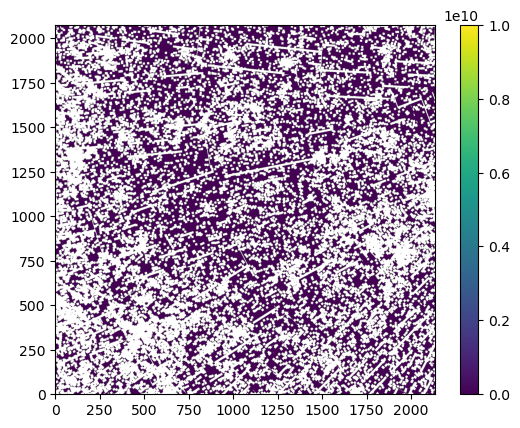

In [47]:
import matplotlib.pyplot as plt

plt.imshow(combined_results[0, 0], origin="lower", vmin=0, vmax=1e10)
plt.colorbar()

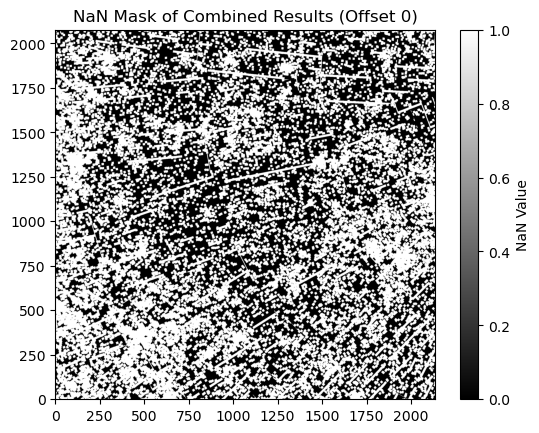

In [39]:
# plot nan values
plt.imshow(np.isnan(combined_results[0, 0]), cmap="gray", origin="lower")
plt.title("NaN Mask of Combined Results (Offset 0)")
plt.colorbar(label="NaN Value")
plt.show()

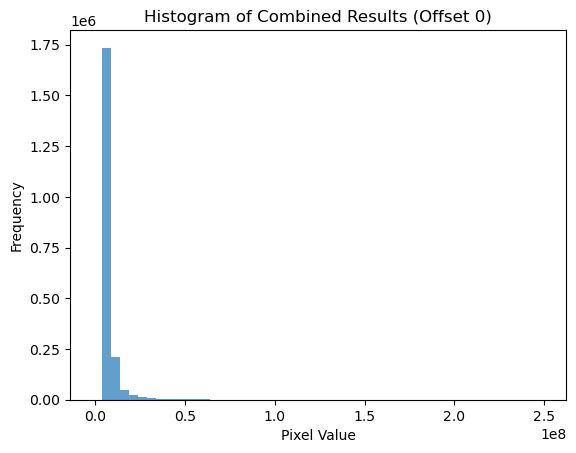

In [40]:
plt.hist(combined_results[0, 0].flatten(), bins=50, alpha=0.7)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Histogram of Combined Results (Offset 0)")
plt.show()

### Step 9: Save Results

In [30]:
# Save outputs as FITS files
print("Saving outputs...")
step_start = time.time()

save_fits_outputs(OUTPUT_DIR, combined_results, offsets, tess_header, save_extensions=True)

print(f"Results saved to: {OUTPUT_DIR}")

# List saved files
saved_files = list(OUTPUT_DIR.glob("*.fits"))
print(f"Number of files saved: {len(saved_files)}")
for f in saved_files:
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"  {f.name}: {size_mb:.2f} MB")

print(f"Time elapsed: {time.time() - step_start:.2f} seconds")

Saving outputs...


AttributeError: '_HeaderComments' object has no attribute 'get'

### Step 10: Summary and Timing Information

In [31]:
# Record processing time and print summary
total_time = time.time() - start_time

print("=" * 60)
print("PROCESSING COMPLETE!")
print("=" * 60)
print(f"Processing completed at: {time.ctime()}")
print(f"Total time: {total_time / 60:.2f} minutes ({total_time:.2f} seconds)")
print(f"Processed {len(reg_files)} skycells in {num_batches} batches")
print(f"Generated {len(offsets)} shifted images")
print(f"Ignored mask bits: {ignore_mask_bits}")
print(f"Padding used: {padding}")
print(f"Parallel jobs: {N_JOBS}")
print(f"Skycells per batch: {SKYCELLS_PER_BATCH}")

print("\nShifts processed:")
for dx, dy in offsets:
    print(f"  dx={dx:6.3f}, dy={dy:6.3f}")

print(f"\nResults saved to: {OUTPUT_DIR}")
print(f"Number of output files: {len(saved_files)}")

# Performance metrics
if len(reg_files) > 0:
    skycells_per_minute = len(reg_files) / (total_time / 60)
    print(f"\nPerformance: {skycells_per_minute:.1f} skycells/minute")

print("=" * 60)

PROCESSING COMPLETE!
Processing completed at: Wed Aug 13 00:06:54 2025
Total time: 3.14 minutes (188.43 seconds)
Processed 20 skycells in 52 batches
Generated 3 shifted images
Ignored mask bits: [5]
Padding used: 480
Parallel jobs: 2
Skycells per batch: 20

Shifts processed:
  dx= 0.000, dy= 0.000
  dx= 0.110, dy= 0.030
  dx=-0.110, dy=-0.030

Results saved to: /home/kshukawa/syndiff/data/shifted_downsamples/sector0020_camera3_ccd3


NameError: name 'saved_files' is not defined